In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import math
import dask
import glob
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from dask.distributed import Client, LocalCluster
if __name__ == "__main__":
    cluster=LocalCluster(host="tcp://127.0.0.1:2419",dashboard_address="127.0.0.1:2429",n_workers=4)
    client = Client(cluster)

In [19]:
files = glob.glob("../FRONT_FILES/2deg/seasonal/*")

models = []
for file in files:
    models.append(file.split('/')[-1].split('_')[0])

In [20]:
dic = {}
for model,file in zip(models,files):
    dic[model] = xr.open_dataset(file)
    dic[model] = dic[model].rename({'__xarray_dataarray_variable__':'front'})
    dic[model] = dic[model].front.fillna(0)
    dic[model] = dic[model].sel(lat = slice(-60,-25))
    dic[model] = dic[model].sel(lon = slice(-30,10))
    dic[model] = dic[model].sortby('lat')
    dic[model] = dic[model].sortby('lon')
    dic[model] = dic[model].sel(time = slice('1950-03-01','2005-11-30')) #change from 1950/1981 here
    dic[model] = dic[model].groupby(dic[model].time.dt.season).mean(dim='time',skipna=True)
    dic[model] = dic[model]/(np.max(dic[model].values))

In [21]:
dic_2deg = dic

In [22]:
weights = np.cos(np.deg2rad(dic_2deg['NOAA'].lat)) #area weighted

In [23]:
#mean absolute error calc
scores=[]
for index in dic_2deg:
    MAE={}
    for season in ['DJF','MAM','JJA','SON']:
        ref = dic_2deg['NOAA'].sel(season = season)
        x = dic_2deg[index].sel(season = season)
        MAE[season] = (np.abs(ref - x)).weighted(weights).sum(('lat','lon'))
    scores.append([index,np.mean(MAE['DJF'].values + MAE['MAM'].values + MAE['JJA'].values + MAE['SON'].values)])

resultsdf = pd.DataFrame(np.array(scores),columns=['model','Score_2deg']).set_index('model')

In [24]:
new_lat = dic_2deg['NOAA'].lat.values
new_lon = dic_2deg['NOAA'].lon.values

In [25]:
files = glob.glob("../FRONT_FILES/native/seasonal/*.nc")

models = []
for file in files:
    models.append(file.split('/')[-1].split('_')[0])

In [26]:
dic = {}
for model,file in zip(models,files): 
    dic[model] = xr.open_dataset(file)
    dic[model] = dic[model].rename({'__xarray_dataarray_variable__':'front'})  
    dic[model] = dic[model].front.fillna(0)
    dic[model] = dic[model].sel(time = slice('1950-03-01','2005-12-30'))  #change from 1950/1981 here
    dic[model] = dic[model].groupby(dic[model].time.dt.season).mean(dim='time',skipna=True)
    dic[model] = dic[model].interp(lat=new_lat, lon=new_lon,method='linear')  #interpolate to 2deg grid
    dic[model] = dic[model].sel(lat = slice(-60,-25))
    dic[model] = dic[model].sel(lon = slice(-30,10))
    dic[model] = dic[model]/(np.max(dic[model].values))

In [27]:
dic_native = dic

In [28]:
#mean absolute error calc
scores=[]
for index in dic_native:
    MAE={}
    for season in ['DJF','MAM','JJA','SON']:
        ref = dic_native['NOAA'].sel(season = season)
        x = dic_native[index].sel(season = season)
        MAE[season] = (np.abs(ref - x)).weighted(weights).sum(('lat','lon'))
    scores.append([index,np.mean(MAE['DJF'].values + MAE['MAM'].values + MAE['JJA'].values + MAE['SON'].values)])

In [29]:
resultsdf['Score_Native'] = pd.DataFrame(np.array(scores),columns=['model','Score_Native']).set_index('model').Score_Native

In [30]:
def getnormalized(df):
    normalized_df=(df-df.min())/(df.max()-df.min())
    return normalized_df

In [31]:
resultsdf.Score_Native = getnormalized(resultsdf.Score_Native.astype(float))
resultsdf.Score_2deg = getnormalized(resultsdf.Score_2deg.astype(float))

In [32]:
resultsdf = resultsdf.sort_values('Score_Native')

In [33]:
resultsdf.to_csv('../FRONT_OUT/scores_1950.csv')

Previously computed by changing time selection above

In [69]:
df = pd.read_csv('../FRONT_OUT/scores_1950.csv').set_index('model')

In [70]:
df_1981 = pd.read_csv('../FRONT_OUT/scores_1981.csv').set_index('model').add_suffix('_1981')

In [71]:
df['Score_Native_1981'] = df_1981.Score_Native_1981
df['Score_2deg_1981'] = df_1981.Score_2deg_1981

In [72]:
df = df.round(2)

In [75]:
df = df.sort_values('Score_2deg_1981')

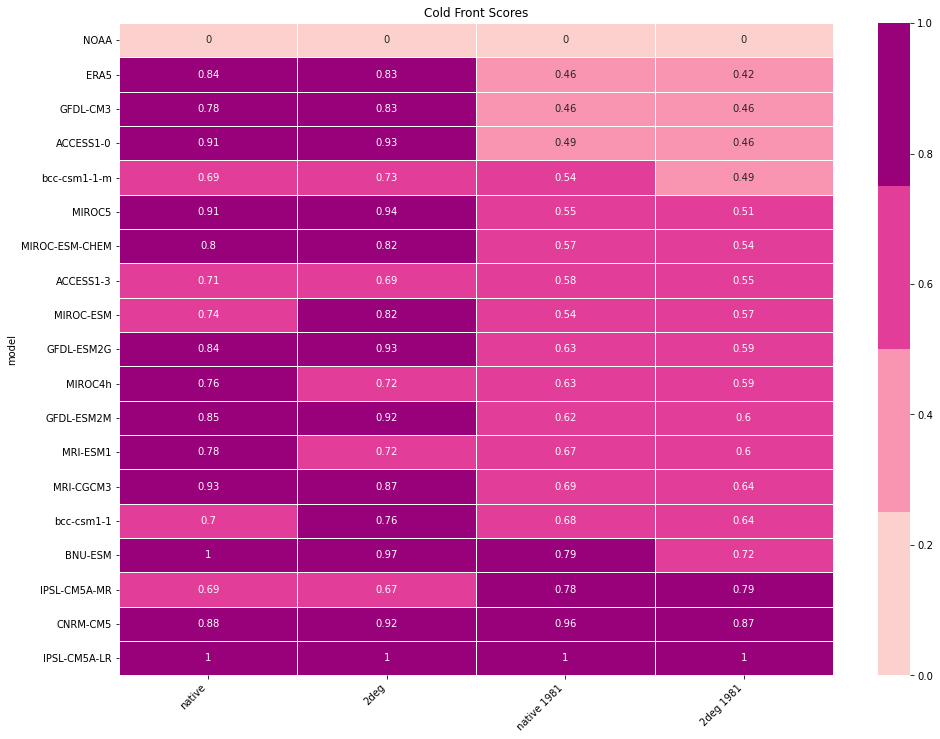

In [76]:
f, ax = plt.subplots(figsize=(16,12))
map = sns.heatmap(df,cmap=sns.color_palette("RdPu", 4), annot=True, linewidths=.5, ax=ax, xticklabels=1, yticklabels=1)
map.set_xticklabels(['native','2deg','native 1981','2deg 1981'],rotation=45,horizontalalignment='right')
plt.title('Cold Front Scores')
plt.savefig('../FRONT_OUT/Scores_heatmap.pdf')
plt.savefig('../FRONT_OUT/Scores_heatmap.png')
plt.show()

In [77]:
client.close()